# Music Emotion Classifier

Import required libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

import pandas as pd
import numpy as np

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

Load Dataset

In [29]:
# Drop unnessary column
#2:"Happy",
#3:"Sad",
#0:"Calm",
#1:"Energetic"

In [2]:
# Connect to Drive to get access to annotated DS
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Load Datasets
df = pd.read_csv('/content/drive/MyDrive/University IE Master/Course/DeepLearning/songs_with_info.csv')
print("\n shape:", df.shape)
df.head()




 shape: (9980, 10)


,acousticness,danceability,liveness,loudness,speechiness,label,x,y,name,artist
0,0.0665,0.615,0.1550,-6.454,0.1350,0,-1.031968,0.122521,...Ready For It?,Taylor Swift
1,0.1000,0.687,0.0452,-4.370,0.0576,2,-3.112131,-0.015127,Hearts Like Ours,The Naked And Famous
2,0.0340,0.818,0.1530,-4.282,0.0797,2,-3.204572,0.060289,Hang Me Up to Dry,Cold War Kids
3,0.0735,0.624,0.3270,-3.374,0.1000,2,-4.108789,-0.017534,Dangerous (feat. Joywave),Big Data
4,0.6070,0.614,0.0986,-10.480,0.0476,1,3.015041,-0.231412,She Sells Sanctuary,The Cult


In [4]:
# Drop all the columns from x to artist
df.drop(df.columns[6:], axis=1, inplace=True)
df.head()

,acousticness,danceability,liveness,loudness,speechiness,label
0,0.0665,0.615,0.1550,-6.454,0.1350,0
1,0.1000,0.687,0.0452,-4.370,0.0576,2
2,0.0340,0.818,0.1530,-4.282,0.0797,2
3,0.0735,0.624,0.3270,-3.374,0.1000,2
4,0.6070,0.614,0.0986,-10.480,0.0476,1


In [5]:
# Split the dataset
X = df.drop(columns=['label'])
y = df['label']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')
print("Scaler saved successfully.")

Scaler saved successfully.


Build the Classifier

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

# Build the neural network
model = Sequential([
    # Input layer
    InputLayer(input_shape=(X_train.shape[1],)),
    # Hidden layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2596 (10.14 KB)
Trainable params: 2596 (10.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
200/200 [==============================] - 2s 6ms/step - loss: 0.6510 - accuracy: 0.7761 - val_loss: 0.3121 - val_accuracy: 0.9311
Epoch 2/50
200/200 [==============================] - 1s 4ms/step - loss: 0.2206 - accuracy: 0.9413 - val_loss: 0.1636 - val_accuracy: 0.9624
Ep

In [7]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {test_acc}')


63/63 [==============================] - 0s 2ms/step - loss: 0.0240 - accuracy: 0.9895
Test accuracy: 0.9894789457321167


63/63 [==============================] - 0s 1ms/step


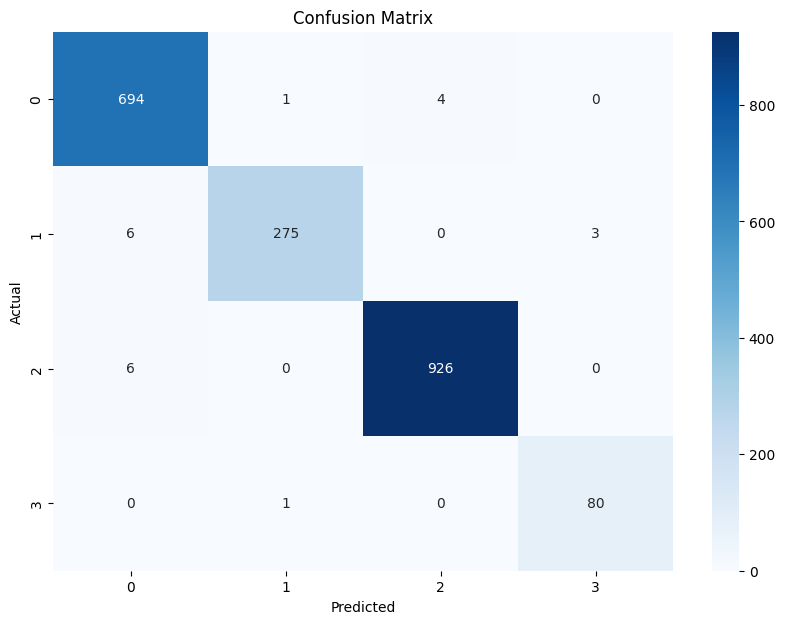

In [8]:
# Plot Confusion Matrices
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [9]:
# Export the model
model.save('music_emotion_classifier.keras')

In [10]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/content/music_emotion_classifier.keras')

# Make predictions on the test set
y_pred = loaded_model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

63/63 [==============================] - 0s 1ms/step


In [41]:
print(y_pred_classes)

[0 0 2 ... 2 2 0]


In [11]:
joblib.dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
# using tensorflow lite to convert the model in a more efficient /  lightweight format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# host tflite_model into a file
with open('music_emotion_classifier.tflite', 'wb') as f:
  f.write(tflite_model)